In [1]:
import scipy.stats as sps
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Set search and chain windows, number of simulated players (<= 500,000), and minimum chain length threshold.

In [2]:
chain_win_start = 7 * 24 * 3600
search_win_end = 10 * 24 * 3600
min_len = 5
nplayers = 30000

Read simulated data from file.

In [3]:
nruns = 0
chain_data = {}
search_data = {}
with open('simulated_data_2w_big.txt', 'r') as f:
    for rs in f:
        rl = rs.split(',')
        r = (int(rl[0]), int(rl[1]), int(rl[2]), int(rl[3]), int(rl[4]), int(rl[5]))
        if r[3] <= search_win_end and r[4] == 0 and r[5] < nplayers:
            nruns += 1
            
            # build dictionaries of runs for fast lookup in the temporal chaining algorithm
            if r[3] >= chain_win_start:
                if r[1] in chain_data:
                    chain_data[r[1]].append(r)
                else:
                    chain_data[r[1]] = [r]

            else:
                target_exp = r[1] + r[2]
                if target_exp in search_data:
                    search_data[target_exp].append(r)
                else:
                    search_data[target_exp] = [r]

Number of simulated players:

In [4]:
nplayers

30000

Number of simulated runs that appear in the data set:

In [5]:
nruns

484554

Run the temporal chaining algorithm.

In [6]:
def links(r1, r2):
    return r1[1] + r1[2] == r2[1] and r2[3] - r2[2] >= r1[3]

In [7]:
# sieves out a chain starting with run i. Deletes all forward-colliding runs
# and their chains        
def chain(exp, k = 0):
    source_runs = chain_data.get(exp, [])
    if len(source_runs) >= k + 1:
        ch = [source_runs.pop(k)]
    else:
        return []
   
    target_exp = ch[0][1] + ch[0][2]
    target_runs = []
    for k, r in enumerate(chain_data.get(target_exp, [])):
        if links(ch[0], r):
            target_runs.append(k)
    
    if len(target_runs) == 1:
        return ch + chain(target_exp, target_runs[0])
    elif len(target_runs) > 1:
        for i, k in enumerate(target_runs):
            chain(target_exp, k - i)
        return ch
    else:
        return ch

In [8]:
# create chains truncating after forward-collisions
cand_chains = []
exp_keys = list(chain_data.keys())
exp_keys.sort()

n = len(exp_keys)
while n > 0:
    ch = chain(exp_keys[0])
    if len(ch) > 0:
        cand_chains.append(ch)
        r = ch[-1]
        target_exp = r[1] + r[2]
        if target_exp in search_data:
            search_data[target_exp].append(r)
        else:
            search_data[target_exp] = [r]
    else:
        exp_keys.pop(0)
        n = len(exp_keys)
        continue

Diagnose chain integrity before back-collision pruning:

In [9]:
players_per_chain = np.zeros(len(cand_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(cand_chains), dtype = int)
nruns = 0

for i, ch in enumerate(cand_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

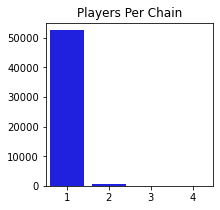

In [10]:
plt.figure(figsize = (3, 3))
plt.subplot
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

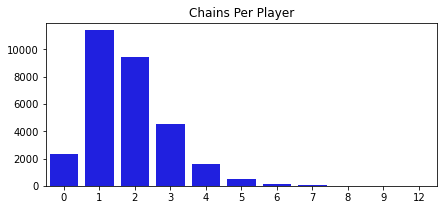

In [11]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

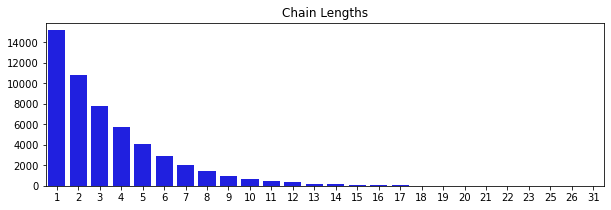

In [12]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [13]:
len(cand_chains)

53121

Total number of runs:

In [14]:
nruns

180971

Proportion of chains containing runs from more than one player:

In [15]:
(players_per_chain > 1).sum() / len(cand_chains)

0.013761036125072946

Spearman rank correlation between chain length and players per chain:

In [16]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.11643698933993027, pvalue=1.049771211363364e-159)

Proportion of players represented in chain data:

In [17]:
(chains_per_player > 0).sum() / nplayers

0.9217

Proportion of represented players that are represented in multiple chains:

In [18]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.5880076669921522

Repeat diagnostic for chains meeting the minumum length threshold.

In [19]:
long_chains = [ch for ch in cand_chains if len(ch) >= min_len]

In [20]:
players_per_chain = np.zeros(len(long_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(long_chains), dtype = int)
nruns = 0

for i, ch in enumerate(long_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

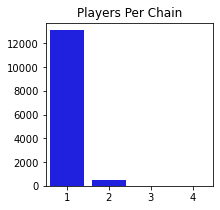

In [21]:
plt.figure(figsize = (3, 3))
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

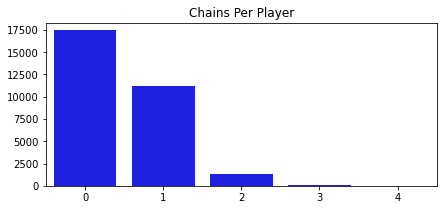

In [22]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

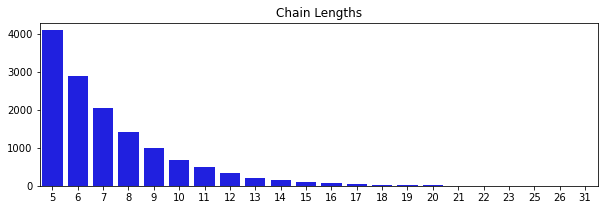

In [23]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [24]:
len(long_chains)

13547

Total remaining runs:

In [25]:
nruns

97649

Proportion of chains containing runs from more than one player:

In [26]:
(players_per_chain > 1).sum() / len(long_chains)

0.03454639403557983

Spearman rank correlation between chain length and players per chain:

In [27]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.06159609283922203, pvalue=7.20862443825564e-13)

Proportion of players represented in chain data:

In [28]:
(chains_per_player > 0).sum() / nplayers

0.4189333333333333

Proportion of represented players that are represented in multiple chains:

In [29]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.10837046467218332

Perform back-collision pruning.

In [30]:
# transfer isolated runs in the chaining dict to the search dict
for r_arr in chain_data.values():
    for r in r_arr:
        target_exp = r[1] + r[2]
        if target_exp in search_data:
            search_data[target_exp].append(r)
        else:
            search_data[target_exp] = [r]

In [31]:
# prune chains after back-collisions
for i in range(len(cand_chains)):
    ch = cand_chains[i]
    for j in range(1, len(ch)):
        trunc = False
        colls = search_data.get(ch[j][1])
        if colls == None: 
            continue

        for r in colls:
            if links(r, ch[j]):
                trunc = True
                break

        if trunc:
            cand_chains[i] = ch[:j]
            break

Diagnose chain integrity after back-collision pruning.

In [32]:
players_per_chain = np.zeros(len(cand_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(cand_chains), dtype = int)
nruns = 0

for i, ch in enumerate(cand_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

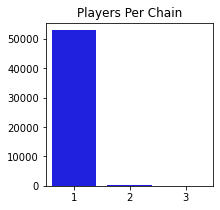

In [33]:
plt.figure(figsize = (3, 3))
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

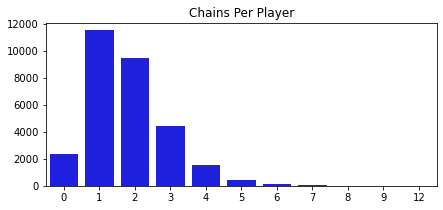

In [34]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

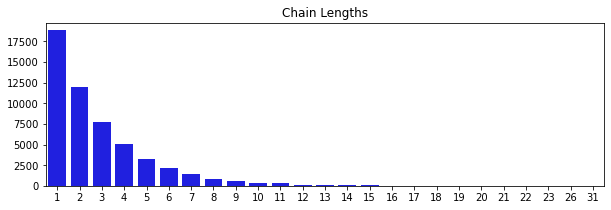

In [35]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [36]:
len(cand_chains)

53121

Total remaining runs:

In [37]:
nruns

151201

Proportion of chains containing runs from more than one player:

In [38]:
(players_per_chain > 1).sum() / len(cand_chains)

0.0040285386193784

Spearman rank correlation between chain length and players per chain:

In [39]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.05345552009496639, pvalue=6.326599455063934e-35)

Proportion of players represented in chain data:

In [40]:
(chains_per_player > 0).sum() / nplayers

0.9206

Proportion of represented players that are represented in multiple chains:

In [41]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.5832066043884423

Repeat diagnostic for chains meeting the minumum length threshold.

In [42]:
long_chains = [ch for ch in cand_chains if len(ch) >= min_len]

In [43]:
players_per_chain = np.zeros(len(long_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(long_chains), dtype = int)
nruns = 0

for i, ch in enumerate(long_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

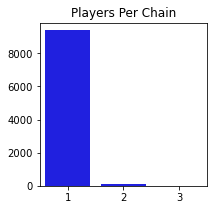

In [44]:
plt.figure(figsize = (3, 3))
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

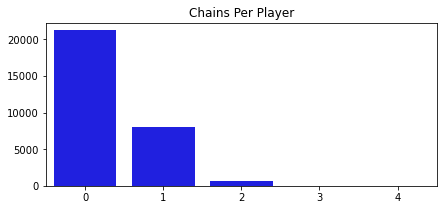

In [45]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

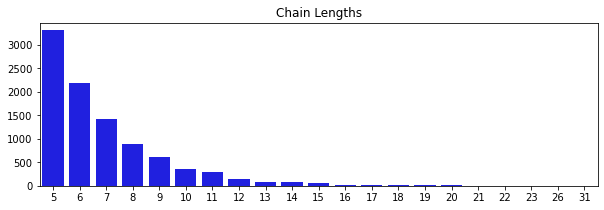

In [46]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [47]:
len(long_chains)

9455

Total remaining runs:

In [48]:
nruns

64692

Proportion of chains containing runs from more than one player:

In [49]:
(players_per_chain > 1).sum() / len(long_chains)

0.008461131676361713

Spearman rank correlation between chain length and players per chain:

In [50]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.004636793101827312, pvalue=0.6521266024487957)

Proportion of players represented in chain data:

In [51]:
(chains_per_player > 0).sum() / nplayers

0.29306666666666664

Proportion of represented players that are represented in multiple chains:

In [52]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.08064149226569609